## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [2]:
import sys
sys.path.append('/home/emastr/phd/')

import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from architecture.fno_1d import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import LinearOperator #, gmres
from operators.stokes_operator import StokesAdjointBoundaryOp
from util.unet import *
import torch.nn as nn
import time

## Create data loader

Load and transform the data. 

In [3]:
def unpack_data(data):
    xlabels = ['x', 'y', 'dx', 'dy', 'ddx', 'ddy', 'vx', 'vy', 'w', 't']
    ylabels = ['rx', 'ry']
    inp = {xlabels[i]: data['X'][:, i, :] for i in range(10)}
    out = {ylabels[i]: data['Y'][:, i, :] for i in range(2)}
    return (inp, out)

def unpack(transform):
    """Decorator for if a method is supposed to act on the values of a dict."""
    def up_transform(data, *args, **kwargs):
        if type(data) == dict:
            return {k: transform(data[k], *args, **kwargs) for k in data.keys()}
        else:
            return transform(data, *args, **kwargs)
    return up_transform

@unpack
def subsample(x, idx):
    return x[idx]

@unpack
def integrate(x, w):
    return torch.cumsum(x * w, axis=len(x.shape)-1)

def subdict(dic, keys):
    return {k: dic[k] for k in keys if k in dic.keys()}

def concat_dict_entries(data):
    return torch.cat(tuple((d[:, None, :] for d in data.values())), dim=1)
    
def arclength(dx, dy, w):
    return integrate((dx**2 + dy**2)**0.5, w)    

def normalize(dx, dy):
    """Normalize 2-dim vector"""
    mag = (dx**2 + dy**2)**0.5
    return dx/mag, dy/mag
    
def curvature(dx, dy, ddx, ddy):
    """Find curvature of line segment given points"""
    mag = (dx**2 + dy**2)**0.5
    return (dx * ddy - dy * ddx) / (mag ** 3)

def invariant_quantities(inp):
    labels = ('tx', 'ty', 'c')
    tx, ty = normalize(inp['dx'], inp['dy'])
    c = curvature(inp['dx'], inp['dy'], inp['ddx'], inp['ddy'])
    data = (tx, ty, c)
    return {labels[i]: data[i] for i in range(len(data))}

Load data

In [4]:
@unpack
def to_dtype(tensor, dtype):
    return tensor.to(dtype)

# Load and transform
data = torch.load(f"/home/emastr/phd/data/problem_data_riesz_TEST.torch")
inp, out = unpack_data(data)

    
dtype = torch.double
inp, out = to_dtype(inp, dtype), to_dtype(out, dtype)

# Add invariant quantities to data.
inp.update(invariant_quantities(inp))

# Normalise curvature using monotone function sigmoid(x/2) - 1/2.
inp['c'] = 1/(1 + torch.exp(-0.5 * inp['c'])) - 0.5 

# REMOVE OUTLIERS:
if True:
    N = inp["x"].shape[0]
    outliers = [ 369,  670, 1005,  382,  925, 1399,  379,  387,  732,  910,   28, 1333, 168, 1197,  113]
    non_outl = [n for n in range(N) if n not in outliers]
    inp = subsample(inp, non_outl)
    out = subsample(out, non_outl)

Split into training and test data

In [5]:
# Standard features (coordinates, derivatives of parameterisation)
features = ['x', 'y', 'dx','dy','ddx','ddy','vx','vy']

# Invariant features (coordinates, tangent, curvature)
features = ['x', 'y', 'tx', 'ty', 'c', 'vx', 'vy']

# Reduced features (trust fourier transform to handle the rest)
#features = {'x', 'y', 'vx', 'vy'}


## TRAINING DATA

M_train = 1500#0
M_batch = 20 # Batch
idx_train = list(range(M_train))
dat_train = subsample(inp, idx_train)
X_train = concat_dict_entries(subdict(dat_train, features))
V_train = concat_dict_entries(subdict(subsample(inp, idx_train), ['vx', 'vy']))
Y_train = concat_dict_entries(subsample(out, idx_train))
#X_train = subdict(X_train, {'vx', 'vy'})

## TEST DATA
M_test = 100#0
idx_test = list(range(M_train, M_test + M_train))
dat_test = subsample(inp, idx_test)
X_test = concat_dict_entries(subdict(dat_test, features))
V_test = concat_dict_entries(subdict(subsample(inp, idx_test),['vx', 'vy']))
Y_test = concat_dict_entries(subsample(out, idx_test))
#X_test = subdict(X_test, {'vx', 'vy'})

in_channels = len(features)
out_channels = 2

Create network

In [6]:
settings = {"modes": 40,
            "input_features": features,
            "weight_decay": 0.0000000,
            "layer_widths": [3*len(features),] * 8}

net = FNO1d(modes=settings["modes"], 
            in_channels=in_channels, 
            out_channels=out_channels, 
            layer_widths=settings["layer_widths"])

Do training

In [6]:
# Predefine list of losses 
trainloss = []
testloss  = []

In [ ]:
# Loss function
loss_fcn  = nn.MSELoss()#L1Loss()
loss_save = nn.MSELoss()
benchloss = loss_fcn(V_test, Y_test).item()
optim     = torch.optim.Adam(net.parameters(), weight_decay=settings["weight_decay"])

# DO TRAINING LOOP 
##################################################
N = 50001 #30001
for i in range(N):
    idx_batch = torch.randperm(M_train)[:M_batch] 
    Y_batch   = Y_train[idx_batch]
    X_batch   = X_train[idx_batch]
    
    # Train on truncated net that expands as iterations progress
    loss = loss_fcn(net(X_batch), Y_batch)
    loss.backward()
    optim.step()
        
    trainloss.append(loss.item())
    testloss.append(loss_save(net(X_test), Y_test).item())
        
    optim.zero_grad()
        
    print(f"Step {i}. Train loss = {trainloss[-1]}, test loss = {testloss[-1]}, benchmark={benchloss}", end="\r")
    
    if i % 1000 == 0:
        torch.save({"state dict" : net.state_dict(), 
                    "settings"   : settings,
                    "trainloss"  : trainloss,
                    "testloss"   : testloss}, 
                    f"/home/emastr/phd/data/fno_big_data_9_{i}.Torch") # old namme unet_state_dict #Kernel size 5, stride 2

In [8]:
save = torch.load(f"/home/emastr/phd/data/runs/fno_big_data_8_{30000}.Torch")
#save = torch.load(f"/home/emastr/phd/data/fno_adjoint_state_dict_2022_12_02_default25_{30000}.Torch")

trainloss = save["trainloss"]
testloss = save["testloss"]
net.load_state_dict(save["state dict"])

<All keys matched successfully>

(-0.8800000131130219,
 0.8800000131130219,
 -0.6743489861488342,
 1.0797309041023255)

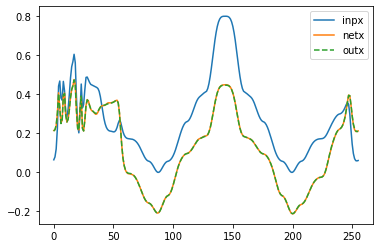

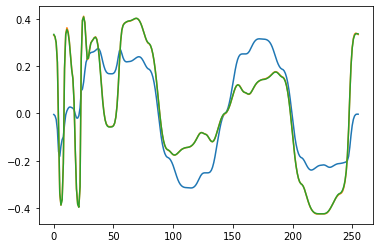

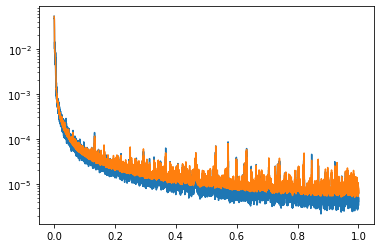

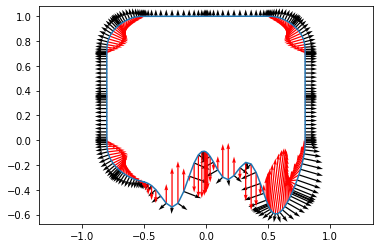

In [9]:
Y_net = net(X_test)
Y_net = Y_net.detach()
for i in [21]:
    plt.figure(1)
    plt.plot(V_test[i, 0, :], label='inpx')
    plt.plot(Y_net[i, 0, :], label='netx')
    plt.plot(Y_test[i, 0, :], '--', label='outx')
    plt.legend()
    plt.figure(2)
    plt.plot(V_test[i, 1, :])
    plt.plot(Y_net[i, 1, :])
    plt.plot(Y_test[i, 1, :])
    
plt.figure(3)
plt.semilogy(np.linspace(0,1,len(trainloss)), trainloss)
plt.semilogy(np.linspace(0,1,len(testloss)), testloss)

plt.figure(4)
plt.plot(inp['x'][0, :], inp['y'][0, :])
plt.quiver(inp['x'][0,:], inp['y'][0,:], inp['dy'][0,:], -inp['dx'][0,:])
plt.quiver(inp['x'][0,:], inp['y'][0,:], inp['ddx'][0,:], inp['ddy'][0,:], color='red')
plt.axis("equal")

Compare to GMRES

In [10]:
from util import gmres

# Create a forward operator
def op_factory(inp):
    Z   = inp['x']   + 1j * inp['y']
    dZ  = inp['dx']  + 1j * inp['dy']
    ddZ = inp['ddx'] + 1j * inp['ddy']
    W = inp['w']
    a = torch.ones(Z.shape[0],) * 0.5 * 1j
    return StokesAdjointBoundaryOp(Z, dZ, ddZ, W, a)

op_test = op_factory(dat_test)

In [11]:
from util.gmres import gmres
from torch import tensordot as dot
from torch.linalg import vector_norm as norm

class gmresNet(nn.Module):
    def __init__(self, steps, callback=None, verbose=False):
        super().__init__()
        self.steps = steps
        self.callback = callback
        self.verbose = verbose
        
        
    def forward(self, x, ops):
        y = torch.zeros_like(x)
        for n in range(x.shape[0]):
            y[n, :] = gmres(lambda x: ops(x, n), x[None, n, :], 
                            steps=self.steps, 
                            callback=self.callback, 
                            verbose=self.verbose)
        return y


In [12]:
# print(V_test.shape)
#ops = [lambda x: torch.cat([op_test(x[r].view(1, C, M), idx=[n]).view(1, C*M) 
                            #for r in range(x.shape[0])], dim=0) for n in range(N)]
# x is shape (C, M) -> 
ops =[]
K = op_test.K
(N, C, M) = V_test.shape

op = lambda x, n: x + dot(x.view(x.shape[0], C, M), K[n, :, :, :, :], [[1,2],[1,3]]).view(x.shape[0], C*M)

vlist =[op(Y_test[None, n].view(1, C*M), n) for n in range(N)]  
V_view = torch.cat(vlist, dim=0)
V_view = V_test.view(N, C*M)
            
#n2 = 10
#print(f"{norm(ops[n](Y_test[None, 11].view(1, C*M)).view(1, C, M) - V_test[None, 11])},{n}")
#callback = lambda *args: print(f"{norm(opnx(Y_test[None, n2].view(1, C*M),n2).view(1, C, M) - V_test[None, n2]):.2e}")

resnet = gmresNet(steps=20)
Y_gmres = resnet(V_view, op).view(N,C,M)

We find corrupt data points by checking for outliers in the training error.

tensor([1496, 1024, 1090,  827, 1192, 1440, 1184,  817, 1089,  913,  418,  822,
        1168, 1259,  319])


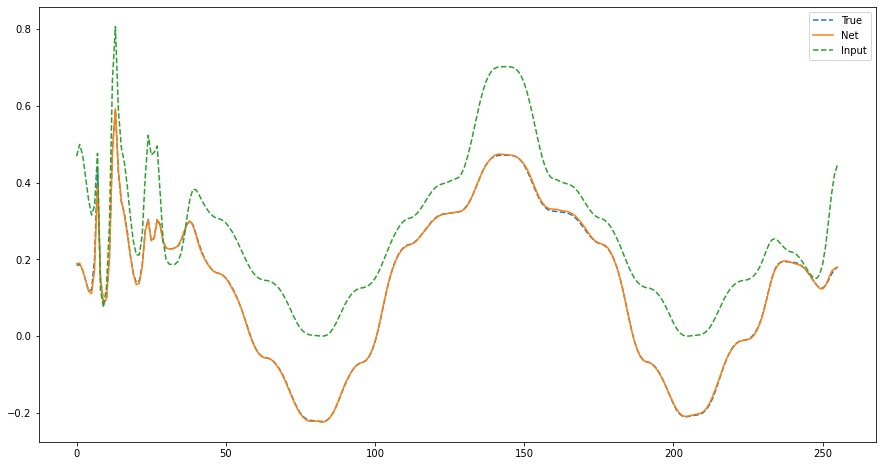

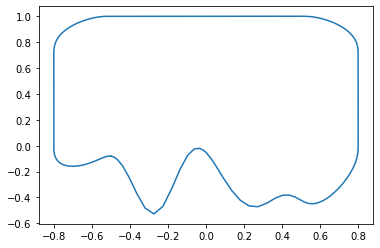

In [13]:
err = (net(X_train) - Y_train).detach()
err = err.reshape(err.shape[0], err.shape[1]*err.shape[2])
err = torch.linalg.vector_norm(err, dim=1)
idx = torch.argsort(err, descending=True)

n = idx[0]
Y_net = net(X_train).detach()

plt.figure(figsize=(15,8))
plt.plot(Y_train[n, 0, :], '--', label="True")
plt.plot(Y_net[n, 0, :], label="Net")
plt.plot(V_train[n, 0, :], '--', label="Input")
#plt.plot(X_train[n, 3, :], '--', label="Input")
plt.legend()

plt.figure()
plt.plot(X_train[n,0,:], X_train[n,1,:])


outliers = idx[0:15]
print(outliers)

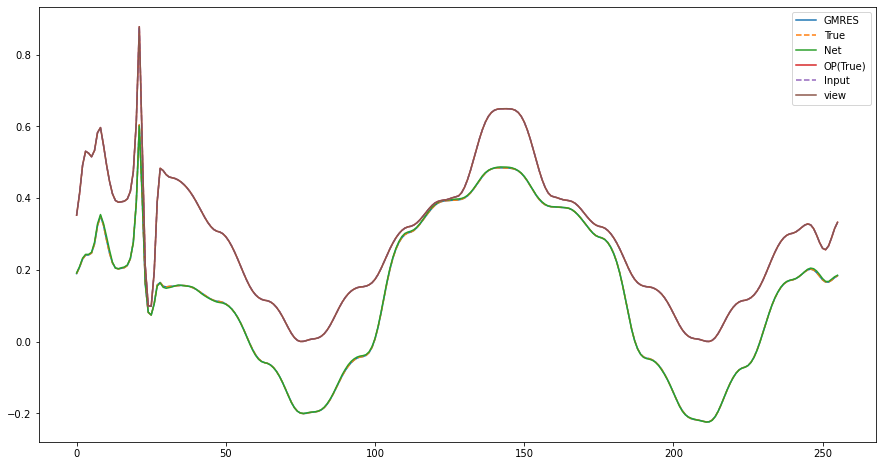

In [14]:
n = 20
t_net = time.time()
Y_net = net(X_test).detach()
t_net = time.time() - t_net

opY = op(Y_test[None, n].view(1, C*M).repeat(2,1), n).view(2, C, M)

plt.figure(figsize=(15,8))
plt.plot(Y_gmres[n, 0, :], label='GMRES')
plt.plot(Y_test[n, 0, :], '--', label="True")
plt.plot(Y_net[n, 0, :], label="Net")
plt.plot(opY[0, 0, :], label="OP(True)")
plt.plot(V_test[n, 0, :], '--', label="Input")
plt.plot(V_view.view(N, C, M)[n,0,:], label='view')

plt.legend()

In [15]:
iters = list(range(2, 23, 3))
times = []
error = []
error2 = []

for i in iters:
    resnet = gmresNet(steps=i)
    
    t = time.time()
    Y_gmres = resnet(V_view, op).view(N,C,M)
    times.append(time.time() - t)
    
    Y_gmresNet = Y_net + resnet(V_view - op_test(Y_net).reshape(N, C*M), op).view(N, C, M)
    error.append(np.array([norm(Y_test[n] - Y_gmres[n])/torch.numel(Y_test[n])**0.5 for n in range(N)]))
    
    error2.append(np.array([norm(Y_test[n] - Y_gmresNet[n])/torch.numel(Y_test[n])**0.5 for n in range(N)]))
    
error3 = np.array([norm(Y_test[n] - Y_net[n])/torch.numel(Y_test[n])**0.5 for n in range(N)])


error_mean = [np.mean(e) for e in error]
error2_mean = [np.mean(e) for e in error2]
error3_mean = np.mean(error3)

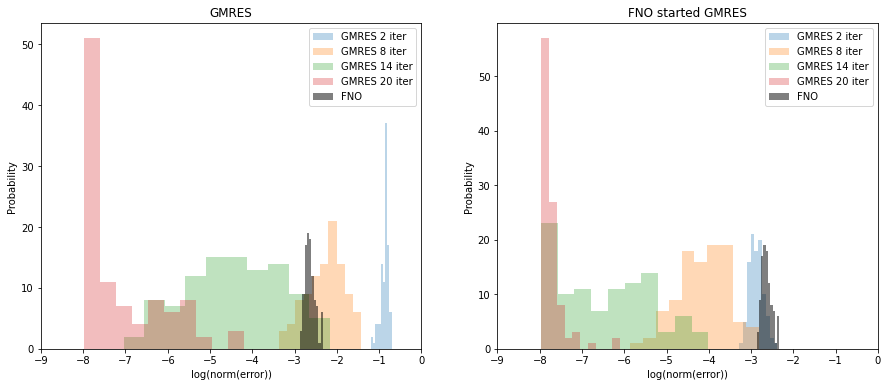

In [18]:
plt.figure(figsize=(15,6))
for i in range(0, len(iters), 2):
    plt.subplot(121)
    plt.hist(np.log10(error[i]), label=f'GMRES {iters[i]} iter', alpha=0.3)
    
    plt.subplot(122)
    plt.hist(np.log10(error2[i]), label=f'GMRES {iters[i]} iter', alpha=0.3)
    
plt.subplot(121)
plt.xlim([-9, 0])
plt.hist(np.log10(error3), label="FNO", color='black', alpha=0.5)
plt.xlabel("log(norm(error))")
plt.ylabel("Probability")
plt.title("GMRES")
plt.legend()

plt.subplot(122)
plt.hist(np.log10(error3), label="FNO", color='black', alpha=0.5)
plt.xlim([-9, 0])
plt.xlabel("log(norm(error))")
plt.ylabel("Probability")
plt.title("FNO started GMRES")
plt.legend()
    


Below, we compare a naive implementation of GMRES (no FMM involved), to FNO.

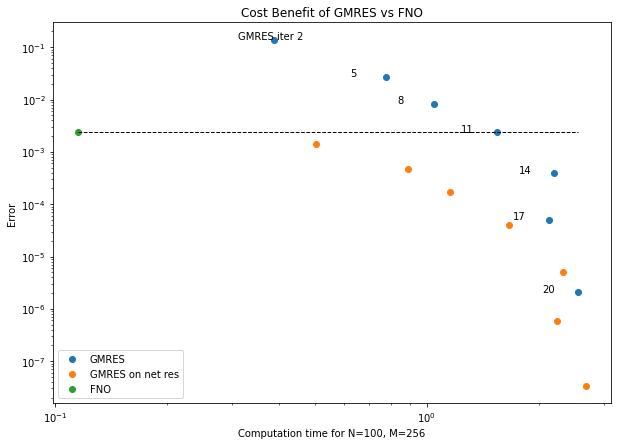

In [17]:
plt.figure(figsize=(10,7))
plt.scatter(times, error_mean, label="GMRES")
plt.scatter([t+t_net for t in times], error2_mean, label="GMRES on net res")
for i in range(len(times)):
    txt = f"{iters[i]}"
    if i == 0:
        txt = "GMRES iter " + txt
    plt.text(times[i]*0.8, error_mean[i], txt)
plt.scatter([t_net], [error3_mean], label="FNO")
plt.plot([t_net] + times, np.ones(len(times)+1)*error3_mean, '--', color='black', linewidth=1)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(f"Computation time for N={N}, M={M}")
plt.ylabel("Error")
plt.title("Cost Benefit of GMRES vs FNO")
plt.legend(loc="lower left")

## Investigate intermediate layers

In [123]:
import torch.nn.functional as F

def forward(net, x, layer):
        
        # Project to FNO width
        x = net.inp(x.permute(0,2,1)).permute(0,2,1)
        
        # Evaluate FNO
        for i in range(layer):
            x = F.gelu(net.conv_list[i](x) + net.lin_list[i](x))
        
        # Project to out_channels width
        return x
    
Y_net_out = forward(net, X_test, 2).detach().cpu()

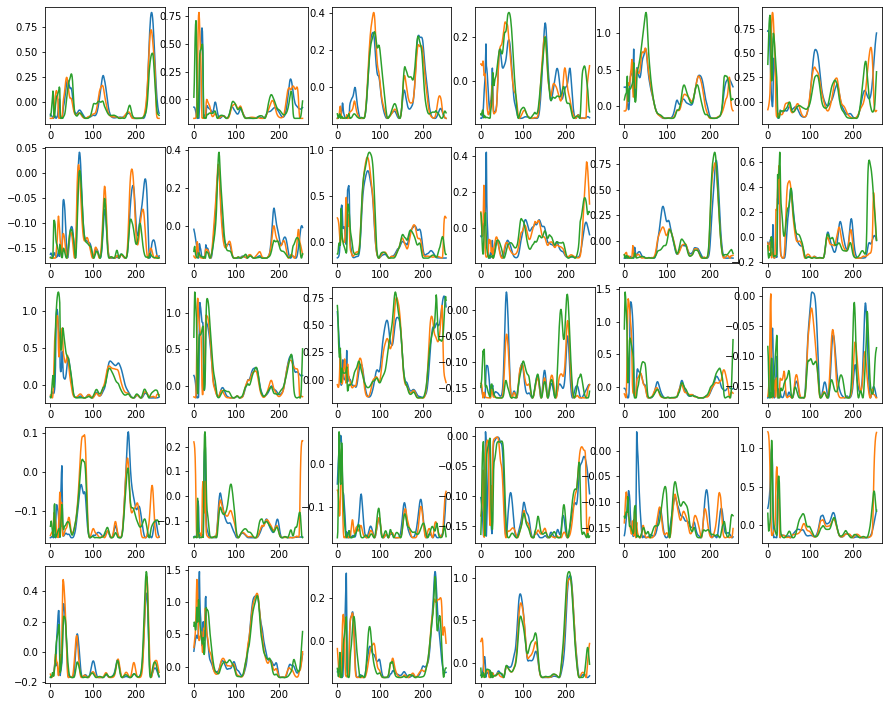

In [124]:
n = 6
plt.figure(figsize=(15,15))
for j in range(3):
    for i in range(Y_net_out.shape[1]):
        plt.subplot(n,n,i+1)
        plt.plot(Y_net_out[j, i, :])

### Visualising Convolution Operations

torch.Size([21, 21, 40])


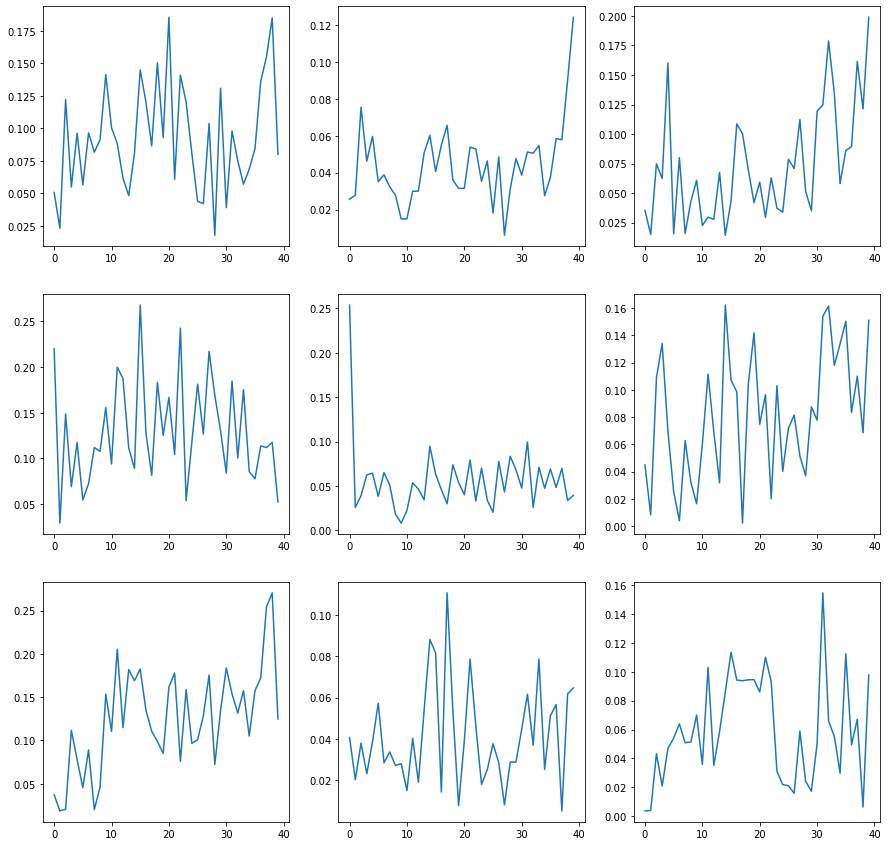

In [20]:
print(net.conv_list[0].weights1.shape)
R = np.abs(net.conv_list[0].weights1.detach().numpy())
#R = torch.fft.irfft(net.conv_list[0].weights1, n=256).detach().numpy()

plt.figure(figsize=(15,15))
N = 3
M = 3
K = 1
for n in range(N):
    for m in range(M):
        plt.subplot(N, M, K)
        plt.plot(R[n,m,:])
        K += 1
        #remove_axes(plt.gca())